In [2]:
# Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt

from scipy.fftpack import dct
import numpy as np
import os
import zipfile

In [3]:
# Define data pre-processing functions 

# Import the mnist dataset 
def import_mnist_data(num_img):
    # Unzip the mnist data
    if not os.path.exists("mnist_dataset/"):
        if os.path.exists("mnist_dataset.zip"):
            with zipfile.ZipFile("mnist_dataset.zip", 'r') as zip_ref:
                zip_ref.extractall("mnist_dataset/")
        else:
            raise FileNotFoundError("mnist_dataset.zip not found.")
    # Load the mnist data
    # Ignore the first column of the data (the label)
    data = np.loadtxt("mnist_dataset/mnist_dataset/mnist_test.csv", delimiter=",", max_rows=num_img, usecols=range(1,785))
    data = data.reshape(num_img, 784)
    return data


# Sparsify the data by setting all values below a threshold to 0
def sparsify_data(data, threshold):
    sparse_data = np.copy(data)
    for i in range(sparse_data.shape[0]):
        for j in range(sparse_data.shape[1]):
            if sparse_data[i,j] < threshold: 
                sparse_data[i,j] = 0

    return sparse_data

# Generates a random measurement matrix with normalized columns
def make_meas_matrix(rows, cols):
    # Generate a matrix of numbers from the standard normal distribution
    meas_matrix = np.random.randn(rows, cols)
    # Normalize the columns of the matrix
    for i in range(cols):
        meas_matrix[:,i] = meas_matrix[:,i] / np.linalg.norm(meas_matrix[:,i])

    return meas_matrix

#we can  use this too and see
def make_dct_meas_matrix(rows, cols):
    D = dct(np.eye(cols), norm='ortho')  
    return D[:rows, :]  

# Generate measurements from the data using the measurement matrix
def get_measurements(data, meas_matrix):
    return np.sign(meas_matrix @ data.T)

# Plot the original image and the estimated image
def plot_est_images(original_data, est_data):
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(original_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[0].set_title("Original Image")
    axs[1].imshow(est_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[1].set_title("Reconstructed Image")
    plt.show()

def plot_rfpi_biht(original_data, rfpi_data, biht_data):
    fig, axs = plt.subplots(1, 3)
    fig.set_figwidth(16)
    axs[0].imshow(original_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[0].set_title("Original Image")
    axs[1].imshow(rfpi_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[1].set_title("RFPI Reconstructed Image")
    axs[2].imshow(biht_data.reshape(28,28), cmap='gray_r', vmin=0, vmax=255)
    axs[2].set_title("BIHT Reconstructed Image")
    plt.show()

def plot_meas_matrix(meas_matrix):
    plt.imshow(meas_matrix, cmap='rainbow', vmin=-1, vmax=1)
    plt.title("Measurement Matrix")
    plt.show()

(1, 784)
(1, 784)


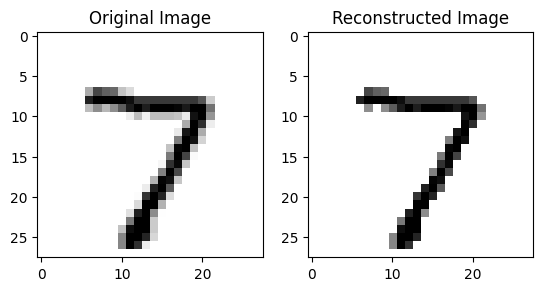

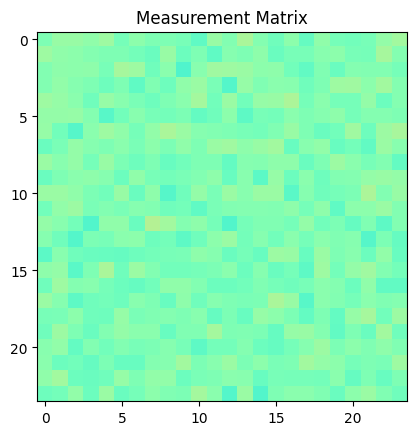

In [4]:
# Testing out data pre-processing functions

data = import_mnist_data(1)
print(data.shape)

sparse_data = sparsify_data(data, 100) #anything below 100 is = zero
print(sparse_data.shape)

plot_est_images(data, sparse_data)

meas_matrix = make_meas_matrix(200,784)
plot_meas_matrix(meas_matrix[0:24,0:24])

measurement = get_measurements(sparse_data, meas_matrix)

**Helper Functions**

In [5]:
def get_k_support(v, k):
    w = np.copy(v)
    support = np.empty(0, dtype=int)
    for i in range(0, k):
        max_index = np.argmax(abs(w))
        support = np.append(support, max_index)
        w[max_index] = 0
    return support

def calculate_normalized_mse(original_data, est_data):
    return np.mean((original_data - est_data)**2) / np.mean(original_data**2)

def calculate_hamming_error(measurement, meas_matrix, est_data):
    return np.count_nonzero(measurement - np.sign(meas_matrix @ est_data))/measurement.shape[0]

def calculate_cosine_similarity(original_data, est_data):
    return (original_data.T @ est_data) / (np.linalg.norm(original_data) * np.linalg.norm(est_data))

def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

**One-bit compressed sensing reconstruction algorithms**

In [6]:
# Sign-truncated matching pursuit: https://arxiv.org/pdf/1312.3418
# not working
def strmp(meas_matrix, measurement, err_threshold, max_iter):
    estimate = np.zeros((meas_matrix.shape[1], 1))
    support = np.empty(0, dtype=int)
    residual = measurement

    c0 = 10
    # Compute first index
    h0 = np.argmax(abs(meas_matrix.T @ residual))
    meas_matrix_h0 = meas_matrix[:,h0]
    meas_matrix_h0c = np.delete(meas_matrix, h0, axis=1)
    C = np.diag(measurement) @ (np.eye(meas_matrix.shape[0]) - np.outer(meas_matrix[:,h0], meas_matrix[:,h0])/np.inner(meas_matrix[:,h0], meas_matrix[:,h0])) @ meas_matrix_h0c
    d = (c0 / np.inner(meas_matrix[:,h0], meas_matrix[:,h0])) @ np.diag(measurement) @ meas_matrix_h0
    iter = 0
    while np.linalg.norm(min((C @ estimate - d), 0))^2 >= 0.1 and iter < max_iter:
        # Matching step
        h = C.T @ min((C @ estimate - d), 0)
        # Support identification step
        k = np.argmax(abs(h))
        # Augment the support vector
        support = np.append(support, k)
        support = np.sort(support)
        # Update estimate
        all_indices = np.arange(meas_matrix.shape[1])  # All column indices
        complement_support = np.setdiff1d(all_indices, support)  # Get complement of support
        estimate[complement_support, :] = 0  # Zero out complement of support
        C_mat = min((C @ estimate - d), 0)
        estimate = np.linalg.inv(C_mat.T @ C_mat) @ (C_mat.T @ measurement)
        # Update residual
        residual = measurement - meas_matrix @ estimate
        iter += 1

    return estimate

# https://link.springer.com/article/10.1007/s11704-017-6132-7?utm_source=chatgpt.com
# https://arxiv.org/pdf/2207.03427
# Binary Iterative Hard Thresholding - assumes we know the sparsity level
# Find a way to dynamically estimate the sparsity
def biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter):

    estimate = np.zeros((meas_matrix.shape[1], 1))
    convergence = []

    iter = 0
    delta = np.linalg.norm(measurement)
    while iter < max_iter and delta > threshold:
        partial_f = (lamda/2) * meas_matrix.T @ (np.sign(measurement) - np.sign(meas_matrix @ estimate))
        last_estimate = estimate
        estimate = estimate + step_size * partial_f
        
        # Hard thresholding
        support = get_k_support(estimate, sparsity)
        temp = np.zeros((meas_matrix.shape[1], 1))
        temp[support,:] = estimate[support,:]
        estimate = temp

        delta = np.linalg.norm(estimate - last_estimate)
        convergence.append(delta)

        iter += 1
    return estimate, convergence

# https://publications.lib.chalmers.se/records/fulltext/164371/local_164371.pdf
# RFPI - Regularized Fixed Point Iteration
def rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter):

    estimate = np.linalg.pinv(meas_matrix) @ measurement
    Y = np.diagflat(measurement)
    iter = 0
    convergence = []

    delta = np.linalg.norm(measurement)
    while iter < max_iter and delta > threshold:
        last_estimate = estimate
        s = (Y @ meas_matrix).T @ np.maximum(np.multiply(measurement, meas_matrix @ estimate), np.zeros_like(measurement))
        g = s - (s.T @ estimate) * estimate 
        h = estimate - step_size * g
        estimate = soft_thresholding(h, step_size/lamda)
        estimate /= np.linalg.norm(estimate)
        iter += 1

        delta = np.linalg.norm(estimate - last_estimate)
        convergence.append(delta)
    return estimate, convergence
    


**Helper function test_algo to test our algorithms on multiple images and measurement matrices**

In [7]:
# Loop to test algorithms on multiple images
def test_algo(algo, num_images, sparse_data, measurement_dims, step_size, lamda, sparsity, threshold, max_iter):

    mses = []
    hamming_errors = [] 

    for m in measurement_dims:
        mse_dim = []
        hamming_error_dim = []
        for idx in range(0,num_images):
            curr_data = sparse_data[idx,:]
            meas_matrix = make_meas_matrix(m,784)
            measurement = np.reshape(get_measurements(curr_data, meas_matrix), (m,1))
            
            if (algo == "rfpi"):
                estimate, convergence = rfpi(meas_matrix, measurement, step_size, lamda, threshold, max_iter)
            elif (algo == "biht"):
                estimate, convergence = biht(meas_matrix, measurement, lamda, step_size, sparsity, threshold, max_iter)

            elif algo == "one_bit_omp":  # NEW: Call your 1-bit OMP
                estimate, _ = one_bit_omp(meas_matrix, measurement.flatten(), sparsity)
                convergence = None  
            
            # Renormalize for plotting
            estimate = abs(estimate) * 255/(np.max(abs(estimate)))
            hamming_error = calculate_hamming_error(measurement, meas_matrix, estimate)
            hamming_error_dim.append(hamming_error)
            mse = calculate_normalized_mse(curr_data, estimate)
            mse_dim.append(mse)


        mses.append(np.mean(mse_dim))
        hamming_errors.append(np.mean(hamming_error_dim))

    return mses, hamming_errors, curr_data, estimate, convergence

**Test the RFPI and BIHT algorithms and compare them**

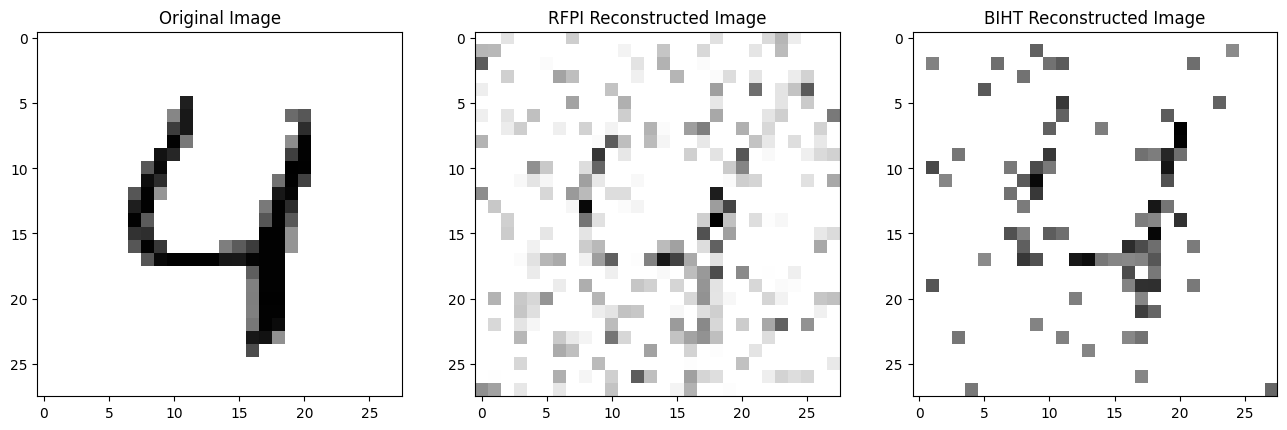

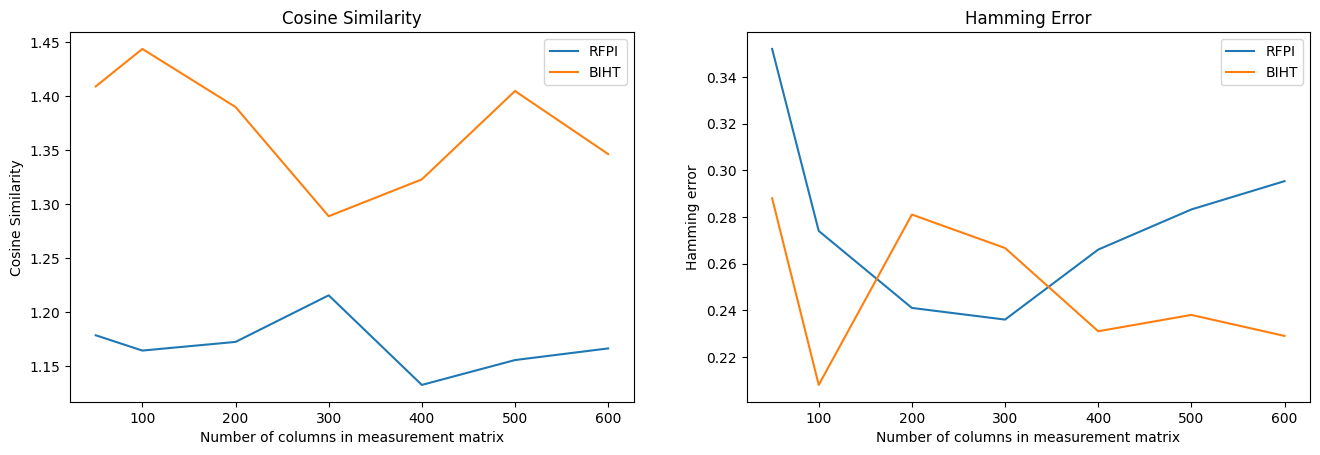

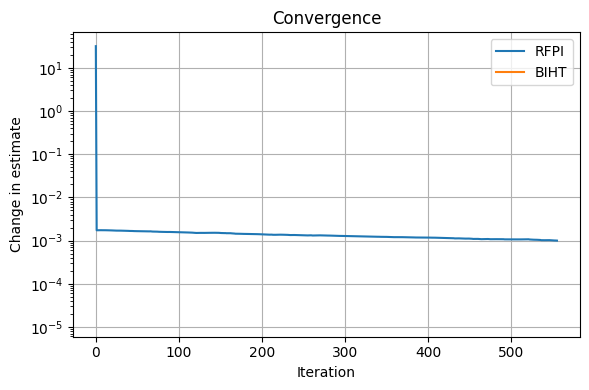

In [8]:
meas_matrix_dims = [50,100,200,300,400,500,600]
num_img = 5
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 100)

mses_rfpi, hamming_errors_rfpi, curr_data, estimate_rfpi, convergence_rfpi = test_algo("rfpi", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 0, 1e-3, 1000)
mses_biht, hamming_errors_biht, curr_data, estimate_biht, convergence_biht = test_algo("biht", num_img, sparse_data, meas_matrix_dims, 1e-5, 0.1, 80, 1e-3, 1000)

plot_rfpi_biht(curr_data, estimate_rfpi, estimate_biht)

fig, axs = plt.subplots(1, 2)
fig.set_figwidth(16)
axs[0].plot(meas_matrix_dims, mses_rfpi)
axs[0].plot(meas_matrix_dims, mses_biht)
axs[0].set_title("Cosine Similarity")
axs[0].set_xlabel("Number of columns in measurement matrix")
axs[0].set_ylabel("Cosine Similarity")
axs[0].legend(["RFPI", "BIHT"])
axs[1].plot(meas_matrix_dims, hamming_errors_rfpi)
axs[1].plot(meas_matrix_dims, hamming_errors_biht)
axs[1].set_title("Hamming Error")
axs[1].set_xlabel("Number of columns in measurement matrix")
axs[1].set_ylabel("Hamming error")
axs[1].legend(["RFPI", "BIHT"])
plt.show()

plt.figure(figsize=(6, 4))
plt.semilogy(convergence_rfpi)
plt.semilogy(convergence_biht)
plt.xlabel("Iteration")
plt.ylabel("Change in estimate")
plt.title("Convergence")
plt.legend(["RFPI", "BIHT"])
plt.grid(True)
plt.tight_layout()
plt.show()


Iterative Shrinkage threshoding algorithm

In [11]:
def soft_thresholding(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

def ista(meas_matrix, measurement, eta, threshold, max_iter):
    estimate = np.zeros((meas_matrix.shape[1], 1))
    convergence = []
    for t in range(max_iter):
        update = estimate - 2 * eta * meas_matrix.T @ (meas_matrix @ estimate - measurement)
        estimate = soft_thresholding(update, threshold)
        diff = np.linalg.norm(update - estimate)
        convergence.append(diff)
        #print(f"Iter {t}: Update norm = {diff:.6f}")

    return estimate, convergence



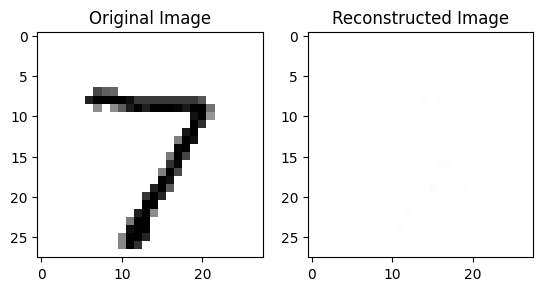

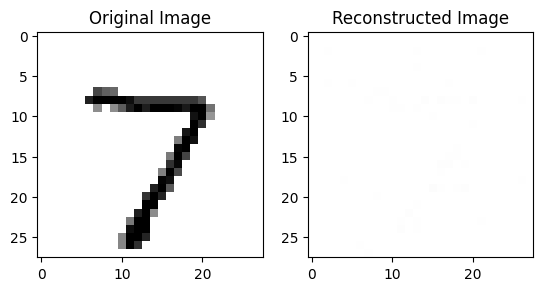

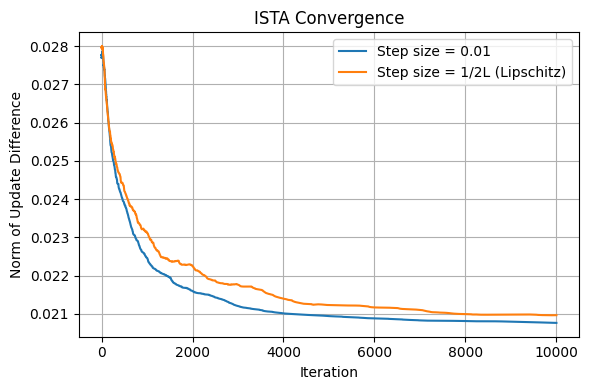

In [55]:
meas_matrix = make_meas_matrix(300,784)
measurement = get_measurements(sparse_data, meas_matrix)

eta = 0.01
estimate, convergence = ista(meas_matrix, measurement, eta, 0.001, 10000)
#estimate = sparsify_data(abs(estimate), 100)
plot_est_images(sparse_data, estimate)

L = np.linalg.norm(meas_matrix.T @ meas_matrix, 2)  # Lipschitz constant
eta = 1 / (2 * L)  
estimate, convergence_lipschitz = ista(meas_matrix, measurement, eta, 0.001, 10000)
#estimate = sparsify_data(abs(estimate), 100)
plot_est_images(sparse_data, estimate)

# Plot convergence 
plt.figure(figsize=(6, 4))
plt.plot(convergence)
plt.plot(convergence_lipschitz)
plt.xlabel("Iteration")
plt.ylabel("Norm of Update Difference")
plt.title("ISTA Convergence")
plt.legend(["Step size = 0.01", "Step size = 1/2L (Lipschitz)"])
plt.grid(True)
plt.tight_layout()
plt.show()

One Bit OMP, MSP, AOP

**One bit OMP**

In [ ]:
def one_bit_omp(A, y, k, max_iters=None, verbose=True):
    m, n = A.shape
    if max_iters is None:
        max_iters = k

    residual = y.copy()
    support = []
    x_est = np.zeros(n)

    for it in range(max_iters):
        if len(support) >= k:
            if verbose:
                print("Reached desired sparsity level.")
            break

        correlations = A.T @ residual

        correlations[support] = 0.0

        i = np.argmax(np.abs(correlations))
        if i in support:
            if verbose:
                print(f"Iteration {it}: Atom {i} already selected. Skipping.")
            continue

        support.append(i)

        A_support = A[:, support]  #use the selected support and get the signa
        x_support = np.linalg.pinv(A_support) @ y
        x_est = np.zeros(n)
        x_est[support] = x_support

        # Step 5: Update residual
        residual = y - np.sign(A @ x_est)

        if verbose:
            print(f"Iteration {it}: Residual norm = {np.linalg.norm(residual):.4f}, Support size = {len(support)}")

        if np.all(residual == 0):
            break

    return x_est, support


Iteration 0: Residual norm = 33.1059, Support size = 1
Iteration 1: Residual norm = 30.6594, Support size = 2
Iteration 2: Residual norm = 29.4618, Support size = 3
Iteration 3: Residual norm = 29.6648, Support size = 4
Iteration 4: Residual norm = 28.6356, Support size = 5
Iteration 5: Residual norm = 28.9137, Support size = 6
Iteration 6: Residual norm = 28.3549, Support size = 7
Iteration 7: Residual norm = 27.6405, Support size = 8
Iteration 8: Residual norm = 28.0713, Support size = 9
Iteration 9: Residual norm = 27.6405, Support size = 10
Iteration 10: Residual norm = 26.7582, Support size = 11
Iteration 11: Residual norm = 26.5330, Support size = 12
Iteration 12: Residual norm = 26.3059, Support size = 13
Iteration 13: Residual norm = 25.2190, Support size = 14
Iteration 14: Residual norm = 25.2982, Support size = 15
Iteration 15: Residual norm = 24.6577, Support size = 16
Iteration 16: Residual norm = 24.1661, Support size = 17
Iteration 17: Residual norm = 23.5797, Support siz

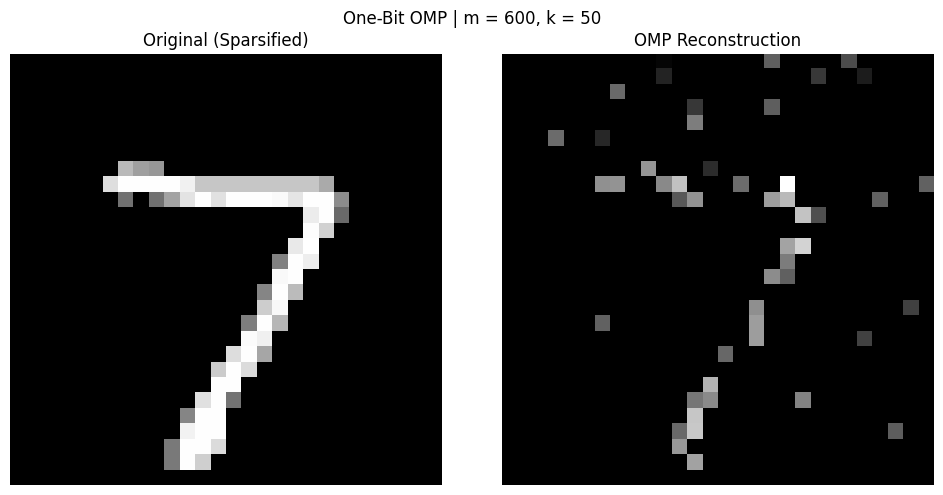

Support overlap: 30 / 78
MSE: 4721.0847
Hamming Error: 0.1167


In [94]:
meas_matrix_dims = [600]
num_img = 1
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 100)
k = 50
noise_std = 0.01

for m in meas_matrix_dims:
    for i in range(num_img):
        x_true = sparse_data[i]
        A = make_meas_matrix(m, 784)

        epsilon = noise_std * np.random.randn(m)
        y = np.sign(A @ x_true + epsilon)

        x_est, support = one_bit_omp(A, y, k=k, max_iters=300,verbose=True)

        x_vis = np.abs(x_est)
        x_vis = x_vis * 255 / np.max(x_vis) if np.max(x_vis) > 0 else x_vis

        plt.figure(figsize=(10, 5))
        plt.suptitle(f"One-Bit OMP | m = {m}, k = {k}")

        plt.subplot(1, 2, 1)
        plt.imshow(x_true.reshape(28, 28), cmap='gray')
        plt.title("Original (Sparsified)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(x_vis.reshape(28, 28), cmap='gray')
        plt.title("OMP Reconstruction")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        x_true_support = np.flatnonzero(x_true)
        recovered_support = np.flatnonzero(x_est)
        overlap = len(set(x_true_support) & set(recovered_support))
        print(f"Support overlap: {overlap} / {len(x_true_support)}")

        mse = np.mean((x_est - x_true) ** 2)
        print(f"MSE: {mse:.4f}")

        sign_match = np.sign(A @ x_est) == np.sign(y)
        hamming_error = 1 - np.mean(sign_match)
        print(f"Hamming Error: {hamming_error:.4f}")


**MSP**

In [ ]:
#MSP algorithm (fixed)
def msp(A, y, k, max_iters=1000, verbose=False):
    m, n = A.shape
    x = np.zeros(n)
    residual = y.copy()
    support_set = set()

    for it in range(max_iters):
        correlations = A.T @ residual
        # Zero out already selected atoms
        for idx in support_set:
            correlations[idx] = 0.0

        i = np.argmax(np.abs(correlations))
        support_set.add(i)

        x[i] += correlations[i]

        if len(support_set) > k:
            x = hard_threshold(x, k)
            support_set = set(np.flatnonzero(x)) #enforce sparsity

        residual = y - np.sign(A @ x)

        if verbose:
            print(f"Iter {it}: residual norm = {np.linalg.norm(residual):.4f}, support size = {np.count_nonzero(x)}")

        if np.all(residual == 0):
            break

    support = np.flatnonzero(x)
    return x, support

def hard_threshold(x, k):
    if k >= len(x):
        return x.copy()
    indices = np.argpartition(np.abs(x), -k)[-k:]
    x_thresh = np.zeros_like(x)
    x_thresh[indices] = x[indices]
    return x_thresh

Iter 0: residual norm = 31.4325, support size = 1
Iter 1: residual norm = 31.4325, support size = 2
Iter 2: residual norm = 30.3315, support size = 3
Iter 3: residual norm = 30.0666, support size = 4
Iter 4: residual norm = 30.1330, support size = 5
Iter 5: residual norm = 29.9333, support size = 6
Iter 6: residual norm = 28.3549, support size = 7
Iter 7: residual norm = 27.8568, support size = 8
Iter 8: residual norm = 27.7849, support size = 9
Iter 9: residual norm = 27.9285, support size = 10
Iter 10: residual norm = 27.4955, support size = 11
Iter 11: residual norm = 26.9072, support size = 12
Iter 12: residual norm = 26.0768, support size = 13
Iter 13: residual norm = 26.3059, support size = 14
Iter 14: residual norm = 26.0768, support size = 15
Iter 15: residual norm = 26.2298, support size = 16
Iter 16: residual norm = 25.9230, support size = 17
Iter 17: residual norm = 25.3772, support size = 18
Iter 18: residual norm = 25.0599, support size = 19
Iter 19: residual norm = 24.331

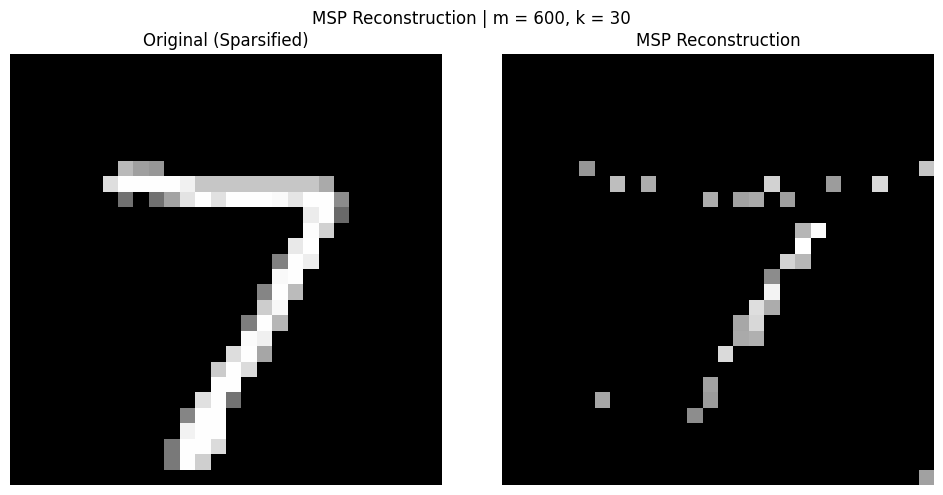

Support overlap: 24 / 78
MSE: 4718.3558
Hamming Error: 0.1967


In [74]:
import numpy as np
import matplotlib.pyplot as plt

meas_matrix_dims = [600]
num_img = 1
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 100)

k = 30  # sparsity level
noise_std = 0.01  # adjust this to simulate stronger/weaker noise

for m in meas_matrix_dims:
    for i in range(num_img):
        x_true = sparse_data[i]
        A = make_meas_matrix(m, 784)

        # Optional: Add noise
        epsilon = noise_std * np.random.randn(m)
        y = np.sign(A @ x_true + epsilon)

        # MSP
        x_est, support = msp(A, y, k=k, max_iters=1000, verbose=True)

        # --- Visual Reconstruction ---
        x_vis = np.abs(x_est)
        x_vis = x_vis * 255 / np.max(x_vis) if np.max(x_vis) > 0 else x_vis

        plt.figure(figsize=(10, 5))
        plt.suptitle(f"MSP Reconstruction | m = {m}, k = {k}")

        plt.subplot(1, 2, 1)
        plt.imshow(x_true.reshape(28, 28), cmap='gray')
        plt.title("Original (Sparsified)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(x_vis.reshape(28, 28), cmap='gray')
        plt.title("MSP Reconstruction")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        x_true_support = np.flatnonzero(x_true)
        recovered_support = np.flatnonzero(x_est)
        overlap = len(set(x_true_support) & set(recovered_support))
        print(f"Support overlap: {overlap} / {len(x_true_support)}")

        mse = np.mean((x_est - x_true) ** 2)
        print(f"MSE: {mse:.4f}")

        sign_match = np.sign(A @ x_est) == np.sign(y)
        hamming_error = 1 - np.mean(sign_match)
        print(f"Hamming Error: {hamming_error:.4f}")



**Convex like approach?**

In [ ]:
#https://deepblue.lib.umich.edu/bitstream/handle/2027.42/98403/21442_ftp.pdf?sequence=1

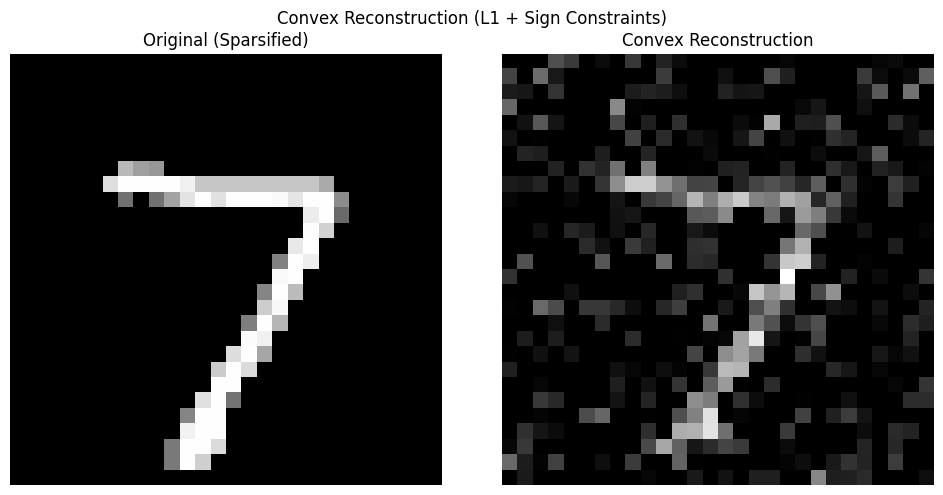

Support overlap: 78 / 78
MSE: 4651.6263
Hamming Error: 0.0000


In [ ]:
import cvxpy as cp



# Setup
meas_matrix_dims = [300]
num_img = 1
data = import_mnist_data(num_img)
sparse_data = sparsify_data(data, 100)
x_true = sparse_data[0]
m, n = 600, 784
A = make_meas_matrix(m, n)
epsilon = 0.01 * np.random.randn(m)
y = np.sign(A @ x_true)

# Convex recovery using CVXPY
x = cp.Variable(n)
objective = cp.Minimize(cp.norm1(x))
constraints = [cp.multiply(y, A @ x) >= 1] #if yi=1, ax=1 product>=1, if yi=-1, ax should be =-1 and product=1
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.SCS)


x_est = x.value

# Visualization
x_vis = np.abs(x_est)
x_vis = x_vis * 255 / np.max(x_vis)

plt.figure(figsize=(10, 5))
plt.suptitle("Convex Reconstruction (L1 + Sign Constraints)")

plt.subplot(1, 2, 1)
plt.imshow(x_true.reshape(28, 28), cmap='gray')
plt.title("Original (Sparsified)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(x_vis.reshape(28, 28), cmap='gray')
plt.title("Convex Reconstruction")
plt.axis('off')
plt.tight_layout()
plt.show()

# Metrics
x_true_support = np.flatnonzero(x_true)
recovered_support = np.flatnonzero(x_est)
overlap = len(set(x_true_support) & set(recovered_support))
mse = np.mean((x_est - x_true) ** 2)
hamming_error = 1 - np.mean(np.sign(A @ x_est) == y)

print(f"Support overlap: {overlap} / {len(x_true_support)}")
print(f"MSE: {mse:.4f}")
print(f"Hamming Error: {hamming_error:.4f}")
